# Ising model using VQE with noise

Import packages:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from qiskit import QuantumCircuit, Aer, assemble, transpile
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA, QNSPSA # optimizers
from qiskit.circuit.library import EfficientSU2 # ansatz
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I # operators
from qiskit.quantum_info import Operator

Defining new LaTeX commands for bra and ket vectors...
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Transverse field Ising model (TFIM) - setup

Here we try to find the ground state energy of TFIM using VQE. The TIFM is given by the Hamiltonian: $$H = -J \sum_{<ij>} Z_i Z_j - h \sum_i X_i.$$
This would give us a degenerate ground state for $h = 0$ (all spins up or all spins down). To avoid this, we break degeneracy by introducing a small magnetic field in the z-direction, $h_z$, by adding to the Hamiltonian the term: $$-h_z \sum_i Z_i.$$ We require that $h_z \ll h$, by a few orders of magnitude.

### Ansatz and optimizers

First, we create an ansatz for our calculation from Ry and CNOT gates. The depth (number of layers) is set to 2 in order to reduce the number of parameters that need to be optimised by a classical optimiser. In this case, we have 12 free parameters.

Our parametrised ansatz is:


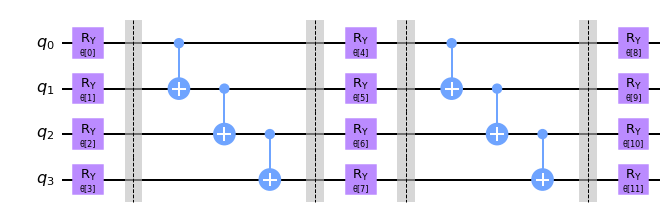

In [68]:
NUM_QUBITS = 4
ansatz = EfficientSU2(NUM_QUBITS, entanglement='linear',
                      insert_barriers=True, su2_gates=['ry'], reps=2)
print("Our parametrised ansatz is:")
display(ansatz.decompose().draw('mpl'))

NOTES ON OPTIMIZERS FOR IDEAL CASE:
- very low tolerance in COBYLA doesn't improve results, even can worsen them, setting a higher tolerance (0.001 to 0.0001) does not improve low-h magnetization, but can help with high-h results. Tolerance  of 0.01 is too large though. The minimum tolerance for after which there is no improvement is 0.00000001.
- Since speed is much improved for higher tolerance, it is probably sufficient to use 0.001.
- After lowering maxiter to 100, the results seem more chaotic. Similarly for 500. Looks good for 1000 and not improved beyond that.
- SLSQP actually runs fast when using kwarg for tolerance 'ftol'


SOLUTION? It seems like the solution is to set the initial point for the optimizer to be biased towards the +1 magnetization state! This is for example all zeroes, but it depends on the ansatz. But then, VQE solutions always falls into the same minimum and don't react to changes in the $h_z$.

### Ising Hamiltonian

Here we define the Ising Hamiltonian operator for n qubits. The $h$ and $J$ parameters correspond to the strength of transverse magnetic field and the coupling constant, respectively.

In [4]:
def ising_hamiltonian(n_qubits, h, h_z=0., J=1.):
    first_term_operators = np.full(n_qubits, I)
    second_term_operators = np.full(n_qubits, I)
    third_term_operators = np.full(n_qubits, I)
    
    first_term_operators[0] = X
    second_term_operators[0] = Z
    second_term_operators[1] = Z
    third_term_operators[0] = Z
    
    first_term = reduce(lambda x, y: x.tensor(y), first_term_operators)
    second_term = reduce(lambda x, y: x.tensor(y), second_term_operators)
    third_term = reduce(lambda x, y: x.tensor(y), third_term_operators)
    
    for i in range(n_qubits-1):
        first_term_operators = np.roll(first_term_operators, 1)
        first_term += reduce(lambda x, y: x.tensor(y), first_term_operators)
        
        second_term_operators = np.roll(second_term_operators, 1)
        second_term += reduce(lambda x, y: x.tensor(y), second_term_operators)
        
        third_term_operators = np.roll(third_term_operators, 1)
        third_term += reduce(lambda x, y: x.tensor(y), third_term_operators)
        
    hamiltonian = - h * first_term - J * second_term - h_z * third_term
    
    return hamiltonian

NOTES: the Ising Hamiltonian is a Hermitian matrix (good), but it is not unitary (bad?). Its determinant, depending on the fields, is in many cases equal to 0, so it is not invertible.

### Ground state energy and eigenvector functions

Find the exact diagonalisation using NumPy function that finds the eigenvalues and eigenvectors of a given matrix:

In [5]:
def find_exact_solution(hamiltonian_matrix):
    num_qubits = int(np.sqrt(hamiltonian_matrix.shape[0]))
    e_values, e_vectors = np.linalg.eigh(hamiltonian_matrix)
    e_values /= num_qubits
    return e_values[0], e_vectors[:, 0]

Function to perform the VQE calculation for a given operator:

In [6]:
def find_VQE_solution(hamiltonian_operator, vqe_instance):
    num_qubits = hamiltonian_operator.num_qubits
    result = vqe_instance.compute_minimum_eigenvalue(hamiltonian_operator)
    energy = result.eigenvalue.real / num_qubits
    opt_params = result.optimal_parameters.values()
    return energy, opt_params

This part tries to simulate the ansatz circuit with the optimal parameters to find the final wavefunction. We use the statevector simulator to find the final state. This will give different results after each optimization (different optimal parametrs found), but the same results each time for the same parametrs of the circuit. The counts will not work, since they would change for every simulation of the circuit (even with the same parametres)!

In [7]:
def find_final_statevector(hamiltonian_operator, opt_params, vqe_instance):
    qc_list = vqe_instance.construct_circuit(opt_params, hamiltonian_operator)
    if len(qc_list) > 1:
        qc = qc_list[1]
    else:
        qc = qc_list[0]
    
    qc = qc.decompose()
    qc.save_statevector()
    
    qobj = assemble(qc)
    result = backend.run(qobj).result()
    final_state = np.asarray(result.get_statevector())

    return final_state

The function below plots the probabilities of different basis states obtained from both VQE and exact diagonalisation, to let us compare them visually:

In [8]:
def plot_state_probabilities(exact_state, vqe_state, h_field):
    # Generate strings representing the computational basis states
    basis_states = [str(bin(x)[2:]) for x in range(2**NUM_QUBITS)]
    basis_states = [x.rjust(4, '0') for x in basis_states]
    
    # Create a figure and plot probabilities
    fig, ax = plt.subplots(figsize=(6, 3))
    x_values = np.arange(2 ** NUM_QUBITS)
    ax.scatter(x_values, abs(exact_state)**2, label="Exact", s=35)
    ax.scatter(x_values, abs(vqe_state)**2, label="VQE", s=35)
    ax.set_ylim(-0.05, 1.05)
    
    # Add some information to the plot
    ax.set_title("h = {0:.3f}".format(h_field), fontsize=14)
    ax.set_xlabel("Computational basis state", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    ax.set_xticks(x_values)
    ax.set_xticklabels(basis_states, rotation=50, fontsize=12)
    ax.legend(fontsize=12, loc='best')
    
    return fig

### Fidelity and magentisation functions

This function computes the fidelity between VQE final state and the exact eigenstate:

In [9]:
def fidelity(exact_state, vqe_state):
    fidelity = np.abs(np.dot(exact_state, vqe_state))**2
    return fidelity

This function creates a list of fidelities given lists of exact and VQE states:

In [10]:
def compute_fidelities(exact_eigvect_list, vqe_eigvect_list):
    fidelity_list = []
    for (exact_state, vqe_state) in zip(exact_eigvect_list, vqe_eigvect_list):
        fid = fidelity(exact_state, vqe_state)
        fidelity_list.append(fid)
    return fidelity_list

Here we define the function to create magnetisation operators:

In [11]:
def magnetisation_operator(n_qubits, axis):
    terms = np.full(n_qubits, I)
    if axis == 'x':
        terms[0] = X
    elif axis =='z':
        terms[0] = Z
    else:
        print("Invalid argument. Axis must be 'x' or 'y'!")
        return None
    
    operator = reduce(lambda x, y: x.tensor(y), terms)
    
    for i in range(n_qubits-1):
        terms = np.roll(terms, 1)
        operator += reduce(lambda x, y: x.tensor(y), terms)
    
    return operator

And here we define the operators themselves:

In [ ]:
x_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'x')
z_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'z')

Function to compute the magnetisation for the exact case. Note that we return the value normalised by the number of qubits.

In [12]:
def exact_magnetisation(magnetisation_operator, eigenvector):
    matrix = magnetisation_operator.to_matrix()
    product = matrix.dot(eigenvector)
    magnetisation = np.vdot(eigenvector, product).real
    return magnetisation / NUM_QUBITS

### Complete calculation and results functions

This is a function that prints all the important results in a nice form:

In [13]:
def print_all_results(results):
    np.set_printoptions(precision=3)
    
    for (h, energy, eigvect, mag, vqe_energy, vqe_eigvect, vqe_mag, fidelity) in results:
        print("\n==================== h = {0:.3f} ====================".format(h))
        
        print("Ground state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(energy, vqe_energy))
        print("MAGNETISATION per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(mag, vqe_mag))
        print("FIDELITY: {0:.3f}".format(fidelity))
        
        print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(eigvect.real, vqe_eigvect.real))
        fig = plot_state_probabilities(eigvect, vqe_eigvect, h)
        display(fig)
        plt.close()

    return

Let's define a function that does the full VQE computation for a given field strength $h$:

In [14]:
def vqe_ising_model(vqe_instance, h_field, h_z=0.001, J=1.):
    hamiltonian_operator = ising_hamiltonian(NUM_QUBITS, h_field, h_z=h_z, J=J)
    
    energy, opt_params = find_VQE_solution(hamiltonian_operator, vqe_instance)
    final_state = find_final_statevector(hamiltonian_operator, opt_params, vqe_instance)
    
    magnetisation_z = vqe_instance.get_energy_evaluation(z_magnetisation_op)(list(opt_params)) / NUM_QUBITS
    magnetisation_x = vqe_instance.get_energy_evaluation(x_magnetisation_op)(list(opt_params)) / NUM_QUBITS
    
    return energy, final_state, magnetisation_z, magnetisation_x

## TFIM on a noisy simulation

### Exact calculation

Define a list of values of magnetic field that we want to investigate and the value of $h_z$ to break degeneracy for small $h$. However, changing $h_z$ also seems to change the position of the phase transition... but only for the exact solution! VQE calculation doesn't seem to be affected.

In [24]:
h_list = (10 ** np.linspace(-1.5, 1.5, 7)).tolist()
h_list.append(1.5)
h_list.append(1.25)
h_list.append(0.75)
h_list.append(2.0)
h_list.sort()

h_bias = 0.1

Here we perform the exact calculation for these field values and then plot the energy and magnetisations:

In [29]:
exact_magnetisation_z_list = []
exact_magnetisation_x_list = []
exact_energy_list = []
exact_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    hamiltonian = ising_hamiltonian(NUM_QUBITS, h, h_z=h_bias)
    exact_energy, exact_eigenvector = find_exact_solution(hamiltonian.to_matrix())
    exact_eigenvector_list.append(exact_eigenvector)
    exact_energy_list.append(exact_energy)
    exact_magnetisation_z_list.append(exact_magnetisation(z_magnetisation_op, exact_eigenvector))
    exact_magnetisation_x_list.append(exact_magnetisation(x_magnetisation_op, exact_eigenvector))
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000
Computing for h = 1.250
Computing for h = 1.500
Computing for h = 2.000
Computing for h = 3.162
Computing for h = 10.000
Computing for h = 31.623
DONE!


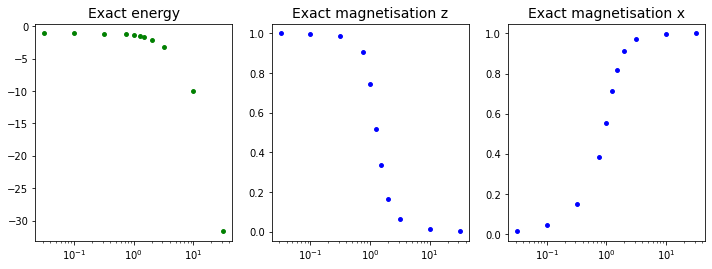

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(h_list, exact_energy_list, s=15, c='g')
axes[0].set_title("Exact energy", fontsize=14)
axes[0].set_xscale('log')
axes[1].scatter(h_list, exact_magnetisation_z_list, s=15, c='b')
axes[1].set_title("Exact magnetisation z", fontsize=14)
axes[1].set_xscale('log')
axes[2].scatter(h_list, exact_magnetisation_x_list, s=15, c='b')
axes[2].set_title("Exact magnetisation x", fontsize=14)
axes[2].set_xscale('log')

### Custom noise model

Now we will define some noise model and add it to our simulation.

In [15]:
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as aer_noise

First, define probabilities of some errors:

In [16]:
prob_err_readout = np.array([[0.995, 0.005], [0.005, 0.995]])
prob_err_single = 0.005
prob_err_double = 0.005

Then, create errors and them to the noise model:

In [17]:
error_single = aer_noise.reset_error(prob_err_single, prob_err_single)
error_double = error_single.tensor(error_single)
error_readout = aer_noise.ReadoutError(prob_err_readout)

noise_model = aer_noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_single, ['rz', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_double, ['cx'])
noise_model.add_all_qubit_readout_error(error_readout)

basis_gates = noise_model.basis_gates

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['sx', 'measure', 'cx', 'id', 'rz']
  All-qubits errors: ['rz', 'sx', 'id', 'cx', 'measure']


Now, we can perform simulations with noise:

In [18]:
opt = SPSA(maxiter=1000)
backend = AerSimulator(noise_model=noise_model)
quantum_instance = QuantumInstance(backend=backend, shots=1024)
vqe_noisy = VQE(ansatz, optimizer=opt,
              quantum_instance=quantum_instance)

In [83]:
vqe_magnetisation_z_list = []
vqe_magnetisation_x_list = []
vqe_energy_list = []
vqe_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    vqe_results = vqe_ising_model(vqe_noisy, h, h_z=h_bias)
    vqe_energy_list.append(vqe_results[0])
    vqe_eigenvector_list.append(vqe_results[1])
    vqe_magnetisation_z_list.append(vqe_results[2])
    vqe_magnetisation_x_list.append(vqe_results[3])
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000
Computing for h = 1.250
Computing for h = 1.500
Computing for h = 2.000
Computing for h = 3.162
Computing for h = 10.000
Computing for h = 31.623
DONE!



==================== h = 0.032 ====================
Ground state ENERGY per qubit:
	Exact: -1.100
	VQE: -0.785
MAGNETISATION per qubit:
	Exact: 1.000
	VQE: 0.725
FIDELITY: 0.425

Ground state EIGENVECTOR:
	Exact: [-9.999e-01 -7.529e-03 -7.529e-03 -1.082e-04 -7.529e-03 -5.669e-05
 -1.082e-04 -1.879e-06 -7.529e-03 -1.082e-04 -5.669e-05 -1.879e-06
 -1.082e-04 -1.879e-06 -1.879e-06 -2.968e-07]
	VQE: [-5.946e-01 -1.984e-03 -1.279e-02 -9.113e-07 -3.404e-02 -8.005e-03
  1.484e-02 -1.381e-02 -7.320e-01 -5.216e-03 -2.595e-02 -8.940e-04
  1.415e-02  7.288e-03  1.509e-02 -1.088e-02]


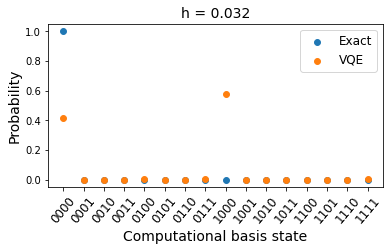


==================== h = 0.100 ====================
Ground state ENERGY per qubit:
	Exact: -1.102
	VQE: -0.608
MAGNETISATION per qubit:
	Exact: 0.999
	VQE: -0.767
FIDELITY: 0.000

Ground state EIGENVECTOR:
	Exact: [-9.989e-01 -2.379e-02 -2.379e-02 -1.082e-03 -2.379e-02 -5.673e-04
 -1.082e-03 -5.989e-05 -2.379e-02 -1.082e-03 -5.673e-04 -5.989e-05
 -1.082e-03 -5.989e-05 -5.989e-05 -2.959e-05]
	VQE: [ 0.007  0.    -0.023  0.    -0.006  0.    -0.002  0.     0.017  0.
 -0.011  0.    -0.007  0.    -0.394  0.   ]


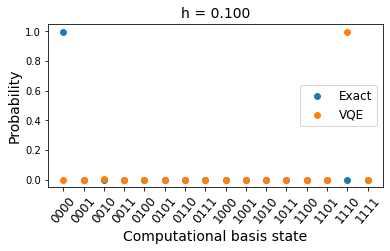


==================== h = 0.316 ====================
Ground state ENERGY per qubit:
	Exact: -1.124
	VQE: -0.778
MAGNETISATION per qubit:
	Exact: 0.988
	VQE: 0.733
FIDELITY: 0.990

Ground state EIGENVECTOR:
	Exact: [-0.988 -0.075 -0.075 -0.011 -0.075 -0.006 -0.011 -0.002 -0.075 -0.011
 -0.006 -0.002 -0.011 -0.002 -0.002 -0.003]
	VQE: [ 5.721e-01 -2.040e-02  4.852e-02  1.225e-04  4.652e-02  2.272e-03
  9.007e-04 -9.969e-04  4.108e-02 -2.261e-03  3.203e-03 -7.468e-04
  1.056e-02 -3.334e-03  2.472e-02  1.118e-02]


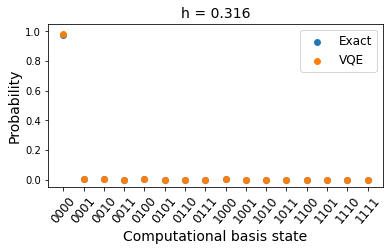


==================== h = 0.750 ====================
Ground state ENERGY per qubit:
	Exact: -1.239
	VQE: -0.900
MAGNETISATION per qubit:
	Exact: 0.906
	VQE: 0.581
FIDELITY: 0.967

Ground state EIGENVECTOR:
	Exact: [-0.925 -0.171 -0.171 -0.062 -0.171 -0.034 -0.062 -0.034 -0.171 -0.062
 -0.034 -0.034 -0.062 -0.034 -0.034 -0.075]
	VQE: [-0.087  0.005 -0.034 -0.015 -0.045 -0.005 -0.024 -0.045 -0.022  0.001
 -0.012 -0.014 -0.003  0.02  -0.04  -0.108]


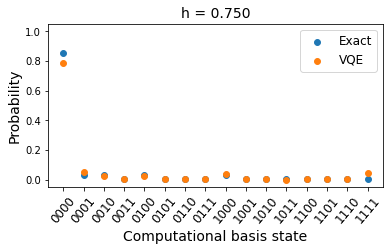


==================== h = 1.000 ====================
Ground state ENERGY per qubit:
	Exact: -1.356
	VQE: -0.963
MAGNETISATION per qubit:
	Exact: 0.747
	VQE: 0.657
FIDELITY: 0.945

Ground state EIGENVECTOR:
	Exact: [-0.837 -0.214 -0.214 -0.109 -0.214 -0.063 -0.109 -0.082 -0.214 -0.109
 -0.063 -0.082 -0.109 -0.082 -0.082 -0.18 ]
	VQE: [-0.421 -0.12  -0.153 -0.051 -0.093  0.004 -0.05   0.007 -0.105 -0.024
 -0.031 -0.004 -0.069 -0.025 -0.033 -0.015]


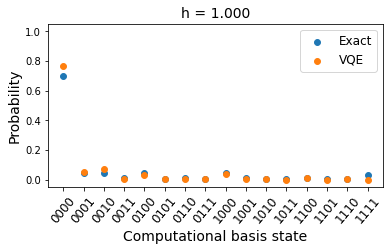


==================== h = 1.250 ====================
Ground state ENERGY per qubit:
	Exact: -1.515
	VQE: -1.120
MAGNETISATION per qubit:
	Exact: 0.517
	VQE: 0.448
FIDELITY: 0.965

Ground state EIGENVECTOR:
	Exact: [-0.717 -0.238 -0.238 -0.154 -0.238 -0.093 -0.154 -0.134 -0.238 -0.154
 -0.093 -0.134 -0.154 -0.134 -0.134 -0.273]
	VQE: [0.257 0.125 0.041 0.054 0.096 0.052 0.049 0.064 0.072 0.038 0.043 0.054
 0.06  0.035 0.067 0.092]


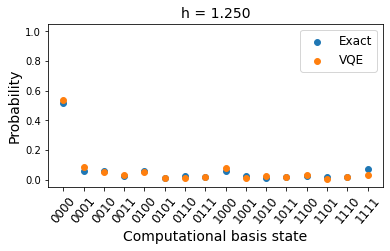


==================== h = 1.500 ====================
Ground state ENERGY per qubit:
	Exact: -1.708
	VQE: -1.262
MAGNETISATION per qubit:
	Exact: 0.338
	VQE: 0.250
FIDELITY: 0.980

Ground state EIGENVECTOR:
	Exact: [-0.612 -0.248 -0.248 -0.184 -0.248 -0.116 -0.184 -0.171 -0.248 -0.184
 -0.116 -0.171 -0.184 -0.171 -0.171 -0.318]
	VQE: [-0.498 -0.252 -0.222 -0.188 -0.204 -0.118 -0.131 -0.156 -0.223 -0.121
 -0.108 -0.131 -0.178 -0.124 -0.16  -0.226]


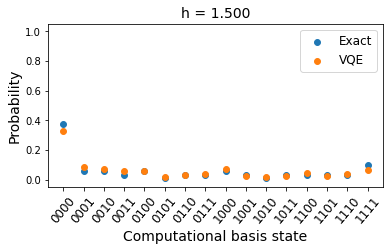


==================== h = 2.000 ====================
Ground state ENERGY per qubit:
	Exact: -2.144
	VQE: -1.547
MAGNETISATION per qubit:
	Exact: 0.167
	VQE: 0.226
FIDELITY: 0.944

Ground state EIGENVECTOR:
	Exact: [-0.485 -0.253 -0.253 -0.215 -0.253 -0.146 -0.215 -0.207 -0.253 -0.215
 -0.146 -0.207 -0.215 -0.207 -0.207 -0.333]
	VQE: [0.435 0.29  0.257 0.187 0.25  0.158 0.194 0.149 0.235 0.2   0.164 0.12
 0.21  0.164 0.166 0.117]


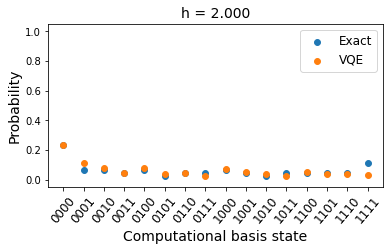


==================== h = 3.162 ====================
Ground state ENERGY per qubit:
	Exact: -3.247
	VQE: -2.321
MAGNETISATION per qubit:
	Exact: 0.065
	VQE: 0.046
FIDELITY: 0.983

Ground state EIGENVECTOR:
	Exact: [0.374 0.254 0.254 0.237 0.254 0.181 0.237 0.232 0.254 0.237 0.181 0.232
 0.237 0.232 0.232 0.312]
	VQE: [-0.285 -0.232 -0.273 -0.218 -0.225 -0.199 -0.259 -0.221 -0.212 -0.197
 -0.205 -0.194 -0.237 -0.248 -0.226 -0.237]


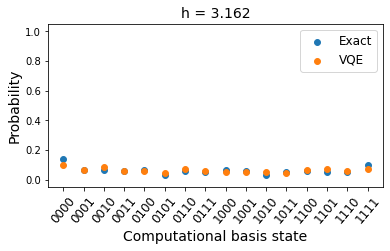


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.026
	VQE: -7.705
MAGNETISATION per qubit:
	Exact: 0.012
	VQE: 0.012
FIDELITY: 0.994

Ground state EIGENVECTOR:
	Exact: [0.282 0.252 0.252 0.249 0.252 0.226 0.249 0.247 0.252 0.249 0.226 0.247
 0.249 0.247 0.247 0.27 ]
	VQE: [-0.053 -0.053 -0.074 -0.074 -0.044 -0.042 -0.065 -0.062 -0.06  -0.06
 -0.08  -0.079 -0.066 -0.066 -0.09  -0.086]


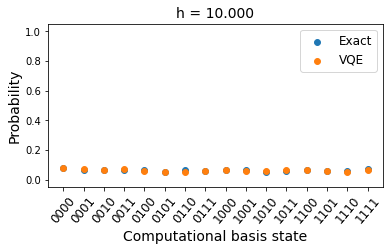


==================== h = 31.623 ====================
Ground state ENERGY per qubit:
	Exact: -31.631
	VQE: -23.563
MAGNETISATION per qubit:
	Exact: 0.003
	VQE: 0.027
FIDELITY: 0.996

Ground state EIGENVECTOR:
	Exact: [0.26  0.251 0.251 0.25  0.251 0.242 0.25  0.249 0.251 0.25  0.242 0.249
 0.25  0.249 0.249 0.256]
	VQE: [-0.035 -0.018 -0.042 -0.025 -0.054 -0.035 -0.059 -0.039 -0.029 -0.035
 -0.043 -0.053 -0.044 -0.046 -0.057 -0.06 ]


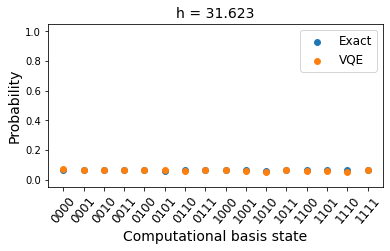

In [84]:
fidelity_list = compute_fidelities(exact_eigenvector_list, vqe_eigenvector_list)
results_list = zip(h_list, exact_energy_list, exact_eigenvector_list, exact_magnetisation_z_list,
                   vqe_energy_list, vqe_eigenvector_list, vqe_magnetisation_z_list, fidelity_list)
print_all_results(results_list)

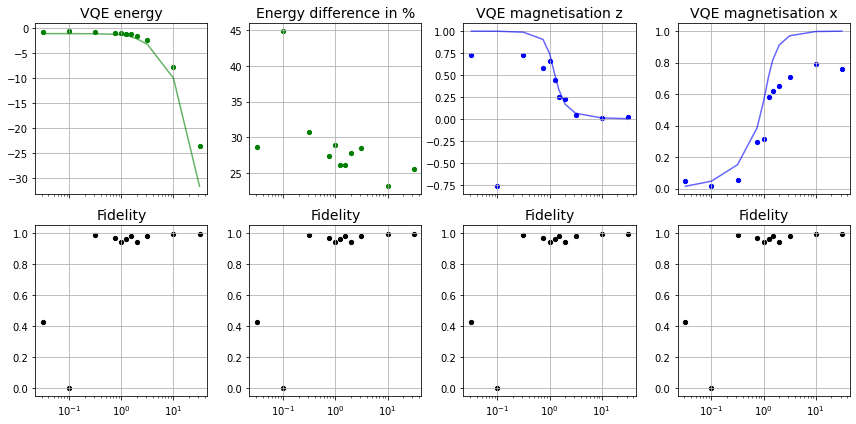

In [85]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)

axes[0, 0].scatter(h_list, vqe_energy_list, s=18, c='g')
axes[0, 0].plot(h_list, exact_energy_list, c='g', alpha=0.6)
axes[0, 0].set_title("VQE energy", fontsize=14)
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True)

axes[0, 1].scatter(h_list, 100 * np.abs((np.array(vqe_energy_list) - np.array(exact_energy_list)) / np.array(exact_energy_list)), s=18, c='g')
axes[0, 1].set_title("Energy difference in %", fontsize=14)
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True)

axes[0, 2].scatter(h_list, vqe_magnetisation_z_list, s=18, c='b')
axes[0, 2].plot(h_list, exact_magnetisation_z_list, c='b', alpha=0.6)
axes[0, 2].set_title("VQE magnetisation z", fontsize=14)
axes[0, 2].grid(True)

axes[0, 3].scatter(h_list, vqe_magnetisation_x_list, s=18, c='b')
axes[0, 3].plot(h_list, exact_magnetisation_x_list, c='b', alpha=0.6)
axes[0, 3].set_title("VQE magnetisation x", fontsize=14)
axes[0, 3].grid(True)

axes[1, 0].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 0].set_ylim(-0.05, 1.05)
axes[1, 0].set_title("Fidelity", fontsize=14)
axes[1, 0].grid(True)

axes[1, 1].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 1].set_ylim(-0.05, 1.05)
axes[1, 1].set_title("Fidelity", fontsize=14)
axes[1, 1].grid(True)

axes[1, 2].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 2].set_ylim(-0.05, 1.05)
axes[1, 2].set_title("Fidelity", fontsize=14)
axes[1, 2].grid(True)

axes[1, 3].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 3].set_ylim(-0.05, 1.05)
axes[1, 3].set_title("Fidelity", fontsize=14)
axes[1, 3].grid(True)

plt.tight_layout()
fig.savefig("spsa_customnoise_1000iter_bias0p1.png")

SPSA might improve results a little bit, but takes extremely long to evaluate! (with maxiter=500)

The results with noise seem pretty bad. with 5% errors, there is no sign of any phase transition whatsoever. With 0.5% errors, there is a phase transition visible in magnetisation plots, but the fidelities are very low.

### IBMQ device noise model

We can import realistic noise models fro real IBM quantum computers.

In [19]:
from qiskit import IBMQ, transpile
from qiskit.providers.fake_provider import FakeBelem

In [20]:
device_backend = FakeBelem()
belem_noise_model = aer_noise.NoiseModel.from_backend(device_backend)
belem_coupling_map = device_backend.configuration().coupling_map
backend = AerSimulator.from_backend(device_backend)
print(belem_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'measure', 'cx', 'id', 'reset', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [109]:
opt = SLSQP(maxiter=1000, ftol=0.00000001)
quantum_instance = QuantumInstance(backend=backend, shots=1024, noise_model=belem_noise_model, coupling_map=belem_coupling_map)
vqe_belem = VQE(ansatz, optimizer=opt,
          quantum_instance=quantum_instance)

In [110]:
vqe_magnetisation_z_list = []
vqe_magnetisation_x_list = []
vqe_energy_list = []
vqe_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    vqe_results = vqe_ising_model(vqe_belem, h, h_z=h_bias)
    vqe_energy_list.append(vqe_results[0])
    vqe_eigenvector_list.append(vqe_results[1])
    vqe_magnetisation_z_list.append(vqe_results[2])
    vqe_magnetisation_x_list.append(vqe_results[3])
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000
Computing for h = 1.250
Computing for h = 1.500
Computing for h = 2.000
Computing for h = 3.162
Computing for h = 10.000
Computing for h = 31.623
DONE!



==================== h = 0.032 ====================
Ground state ENERGY per qubit:
	Exact: -1.100
	VQE: -0.111
MAGNETISATION per qubit:
	Exact: 1.000
	VQE: 0.029
FIDELITY: 0.102

Ground state EIGENVECTOR:
	Exact: [-9.999e-01 -7.529e-03 -7.529e-03 -1.082e-04 -7.529e-03 -5.669e-05
 -1.082e-04 -1.879e-06 -7.529e-03 -1.082e-04 -5.669e-05 -1.879e-06
 -1.082e-04 -1.879e-06 -1.879e-06 -2.968e-07]
	VQE: [ 0.169  0.084  0.378 -0.395  0.178 -0.098  0.154 -0.025 -0.136 -0.066
 -0.009 -0.137  0.087  0.055  0.382  0.248]


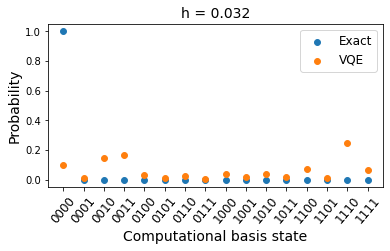


==================== h = 0.100 ====================
Ground state ENERGY per qubit:
	Exact: -1.102
	VQE: 0.052
MAGNETISATION per qubit:
	Exact: 0.999
	VQE: 0.099
FIDELITY: 0.037

Ground state EIGENVECTOR:
	Exact: [-9.989e-01 -2.379e-02 -2.379e-02 -1.082e-03 -2.379e-02 -5.673e-04
 -1.082e-03 -5.989e-05 -2.379e-02 -1.082e-03 -5.673e-04 -5.989e-05
 -1.082e-03 -5.989e-05 -5.989e-05 -2.959e-05]
	VQE: [ 0.198 -0.173 -0.369  0.027  0.164  0.327  0.105  0.104  0.166  0.256
 -0.23  -0.114 -0.127  0.171 -0.355 -0.018]


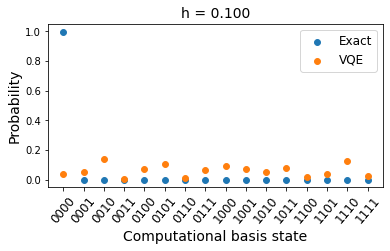


==================== h = 0.316 ====================
Ground state ENERGY per qubit:
	Exact: -1.124
	VQE: -0.150
MAGNETISATION per qubit:
	Exact: 0.988
	VQE: -0.235
FIDELITY: 0.028

Ground state EIGENVECTOR:
	Exact: [-0.988 -0.075 -0.075 -0.011 -0.075 -0.006 -0.011 -0.002 -0.075 -0.011
 -0.006 -0.002 -0.011 -0.002 -0.002 -0.003]
	VQE: [ 0.078  0.072  0.172  0.129  0.051 -0.218  0.152  0.043 -0.092 -0.069
  0.018 -0.068 -0.083 -0.009 -0.373 -0.356]


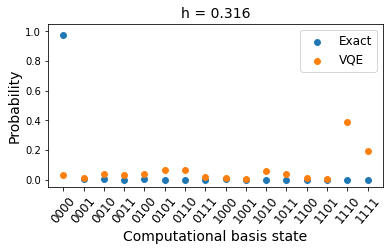


==================== h = 0.750 ====================
Ground state ENERGY per qubit:
	Exact: -1.239
	VQE: -0.109
MAGNETISATION per qubit:
	Exact: 0.906
	VQE: -0.172
FIDELITY: 0.001

Ground state EIGENVECTOR:
	Exact: [-0.925 -0.171 -0.171 -0.062 -0.171 -0.034 -0.062 -0.034 -0.171 -0.062
 -0.034 -0.034 -0.062 -0.034 -0.034 -0.075]
	VQE: [ 0.003 -0.22   0.024  0.216 -0.031  0.076  0.012  0.42   0.044 -0.34
 -0.057 -0.321  0.004  0.031  0.016  0.032]


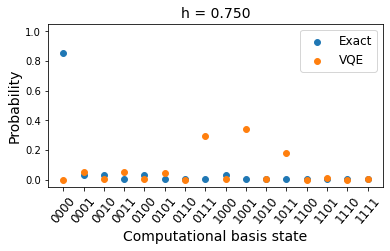


==================== h = 1.000 ====================
Ground state ENERGY per qubit:
	Exact: -1.356
	VQE: 0.035
MAGNETISATION per qubit:
	Exact: 0.747
	VQE: -0.108
FIDELITY: 0.025

Ground state EIGENVECTOR:
	Exact: [-0.837 -0.214 -0.214 -0.109 -0.214 -0.063 -0.109 -0.082 -0.214 -0.109
 -0.063 -0.082 -0.109 -0.082 -0.082 -0.18 ]
	VQE: [ 0.028  0.325  0.067 -0.306 -0.093 -0.13   0.109 -0.081 -0.005  0.317
 -0.224  0.33  -0.123  0.11  -0.099 -0.232]


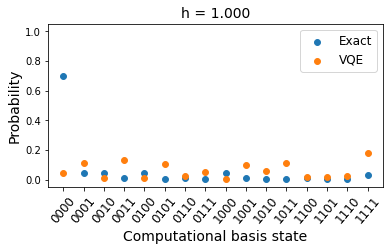


==================== h = 1.250 ====================
Ground state ENERGY per qubit:
	Exact: -1.515
	VQE: 0.034
MAGNETISATION per qubit:
	Exact: 0.517
	VQE: 0.050
FIDELITY: 0.004

Ground state EIGENVECTOR:
	Exact: [-0.717 -0.238 -0.238 -0.154 -0.238 -0.093 -0.154 -0.134 -0.238 -0.154
 -0.093 -0.134 -0.154 -0.134 -0.134 -0.273]
	VQE: [ 0.043  0.133 -0.088 -0.01  -0.239  0.027 -0.034  0.164 -0.105 -0.114
  0.283 -0.253  0.322 -0.056  0.155 -0.006]


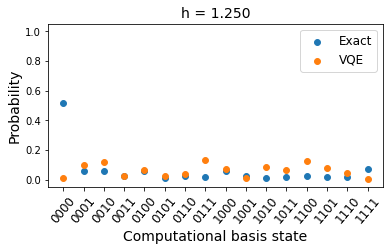


==================== h = 1.500 ====================
Ground state ENERGY per qubit:
	Exact: -1.708
	VQE: -0.048
MAGNETISATION per qubit:
	Exact: 0.338
	VQE: 0.088
FIDELITY: 0.009

Ground state EIGENVECTOR:
	Exact: [-0.612 -0.248 -0.248 -0.184 -0.248 -0.116 -0.184 -0.171 -0.248 -0.184
 -0.116 -0.171 -0.184 -0.171 -0.171 -0.318]
	VQE: [-0.202  0.155 -0.281 -0.     0.209  0.2   -0.051  0.17   0.313 -0.032
  0.284  0.004  0.072 -0.128 -0.148 -0.269]


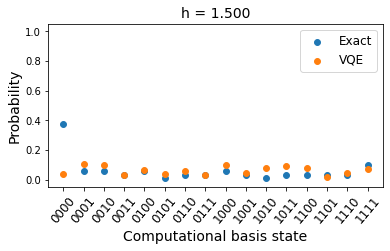


==================== h = 2.000 ====================
Ground state ENERGY per qubit:
	Exact: -2.144
	VQE: 0.263
MAGNETISATION per qubit:
	Exact: 0.167
	VQE: 0.270
FIDELITY: 0.103

Ground state EIGENVECTOR:
	Exact: [-0.485 -0.253 -0.253 -0.215 -0.253 -0.146 -0.215 -0.207 -0.253 -0.215
 -0.146 -0.207 -0.215 -0.207 -0.207 -0.333]
	VQE: [ 0.415 -0.033 -0.242  0.057  0.177  0.324 -0.039  0.26  -0.174 -0.012
  0.29   0.095 -0.018  0.019  0.137 -0.054]


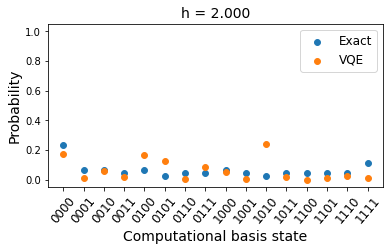


==================== h = 3.162 ====================
Ground state ENERGY per qubit:
	Exact: -3.247
	VQE: 0.169
MAGNETISATION per qubit:
	Exact: 0.065
	VQE: -0.066
FIDELITY: 0.106

Ground state EIGENVECTOR:
	Exact: [0.374 0.254 0.254 0.237 0.254 0.181 0.237 0.232 0.254 0.237 0.181 0.232
 0.237 0.232 0.232 0.312]
	VQE: [ 0.008 -0.088 -0.148  0.304  0.253  0.008 -0.389  0.135  0.222  0.084
 -0.112 -0.059 -0.001  0.192 -0.068 -0.007]


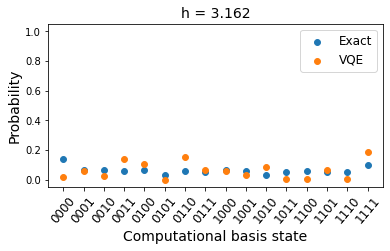


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.026
	VQE: -0.358
MAGNETISATION per qubit:
	Exact: 0.012
	VQE: 0.052
FIDELITY: 0.015

Ground state EIGENVECTOR:
	Exact: [0.282 0.252 0.252 0.249 0.252 0.226 0.249 0.247 0.252 0.249 0.226 0.247
 0.249 0.247 0.247 0.27 ]
	VQE: [-0.15  -0.376 -0.059 -0.047  0.037  0.097 -0.047  0.039 -0.135  0.177
 -0.033  0.255  0.255  0.371  0.059  0.044]


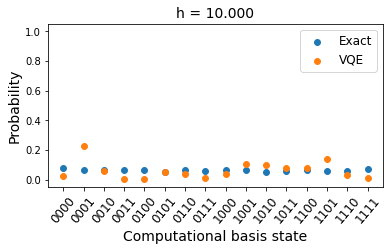


==================== h = 31.623 ====================
Ground state ENERGY per qubit:
	Exact: -31.631
	VQE: 4.774
MAGNETISATION per qubit:
	Exact: 0.003
	VQE: 0.027
FIDELITY: 0.036

Ground state EIGENVECTOR:
	Exact: [0.26  0.251 0.251 0.25  0.251 0.242 0.25  0.249 0.251 0.25  0.242 0.249
 0.25  0.249 0.249 0.256]
	VQE: [-0.266  0.144  0.001  0.112  0.066  0.173  0.02  -0.4    0.329 -0.347
 -0.021  0.051  0.156  0.043  0.178 -0.242]


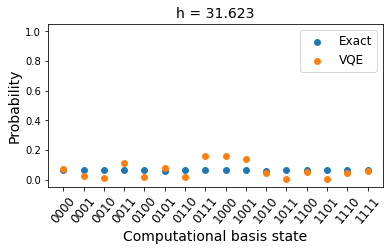

In [111]:
fidelity_list = compute_fidelities(exact_eigenvector_list, vqe_eigenvector_list)
results_list = zip(h_list, exact_energy_list, exact_eigenvector_list, exact_magnetisation_z_list,
                   vqe_energy_list, vqe_eigenvector_list, vqe_magnetisation_z_list, fidelity_list)
print_all_results(results_list)

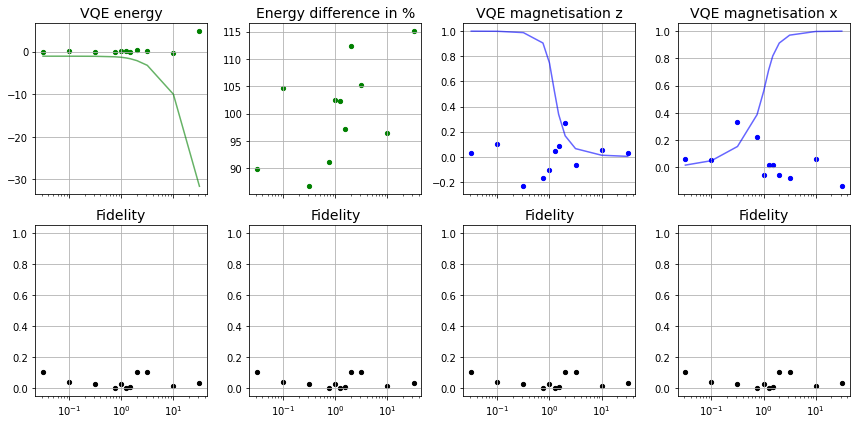

In [112]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)

axes[0, 0].scatter(h_list, vqe_energy_list, s=18, c='g')
axes[0, 0].plot(h_list, exact_energy_list, c='g', alpha=0.6)
axes[0, 0].set_title("VQE energy", fontsize=14)
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True)

axes[0, 1].scatter(h_list, 100 * np.abs((np.array(vqe_energy_list) - np.array(exact_energy_list)) / np.array(exact_energy_list)), s=18, c='g')
axes[0, 1].set_title("Energy difference in %", fontsize=14)
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True)

axes[0, 2].scatter(h_list, vqe_magnetisation_z_list, s=18, c='b')
axes[0, 2].plot(h_list, exact_magnetisation_z_list, c='b', alpha=0.6)
axes[0, 2].set_title("VQE magnetisation z", fontsize=14)
axes[0, 2].grid(True)

axes[0, 3].scatter(h_list, vqe_magnetisation_x_list, s=18, c='b')
axes[0, 3].plot(h_list, exact_magnetisation_x_list, c='b', alpha=0.6)
axes[0, 3].set_title("VQE magnetisation x", fontsize=14)
axes[0, 3].grid(True)

axes[1, 0].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 0].set_ylim(-0.05, 1.05)
axes[1, 0].set_title("Fidelity", fontsize=14)
axes[1, 0].grid(True)

axes[1, 1].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 1].set_ylim(-0.05, 1.05)
axes[1, 1].set_title("Fidelity", fontsize=14)
axes[1, 1].grid(True)

axes[1, 2].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 2].set_ylim(-0.05, 1.05)
axes[1, 2].set_title("Fidelity", fontsize=14)
axes[1, 2].grid(True)

axes[1, 3].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 3].set_ylim(-0.05, 1.05)
axes[1, 3].set_title("Fidelity", fontsize=14)
axes[1, 3].grid(True)

plt.tight_layout()
fig.savefig("slsqp_ibmnoise_1000iter_bias0p1.png")

These results are a bit better then my customnoise model. The magnetisation and energy plots look okay and energy errors are much smaller. However, fidelity is still extremely low, apart from phase transition?!

### Adding measurement error mitigation to IBM device noise

In [21]:
from qiskit.utils.mitigation import CompleteMeasFitter

In [63]:
opt = SPSA(maxiter=100)
quantum_instance = QuantumInstance(backend=backend, shots=1024,
                                   noise_model=belem_noise_model,
                                   coupling_map=belem_coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter)
vqe_mit = VQE(ansatz, optimizer=opt,
              quantum_instance=quantum_instance)

In [65]:
vqe_magnetisation_z_list = []
vqe_magnetisation_x_list = []
vqe_energy_list = []
vqe_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    vqe_results = vqe_ising_model(vqe_mit, h, h_z=h_bias)
    vqe_energy_list.append(vqe_results[0])
    vqe_eigenvector_list.append(vqe_results[1])
    vqe_magnetisation_z_list.append(vqe_results[2])
    vqe_magnetisation_x_list.append(vqe_results[3])
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000
Computing for h = 1.250
Computing for h = 1.500
Computing for h = 2.000
Computing for h = 3.162
Computing for h = 10.000
Computing for h = 31.623
DONE!



==================== h = 0.032 ====================
Ground state ENERGY per qubit:
	Exact: -1.100
	VQE: -0.750
MAGNETISATION per qubit:
	Exact: 1.000
	VQE: 0.616
FIDELITY: 0.986

Ground state EIGENVECTOR:
	Exact: [-9.999e-01 -7.529e-03 -7.529e-03 -1.082e-04 -7.529e-03 -5.669e-05
 -1.082e-04 -1.879e-06 -7.529e-03 -1.082e-04 -5.669e-05 -1.879e-06
 -1.082e-04 -1.879e-06 -1.879e-06 -2.968e-07]
	VQE: [ 9.925e-01  1.068e-01  9.620e-06 -2.704e-04  8.626e-03 -8.339e-04
 -2.395e-03  2.463e-03 -1.072e-02  7.900e-04  2.119e-03 -4.005e-03
 -9.516e-03  2.162e-02  2.445e-02 -4.582e-02]


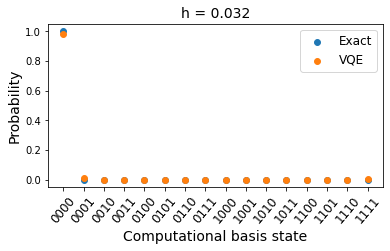


==================== h = 0.100 ====================
Ground state ENERGY per qubit:
	Exact: -1.102
	VQE: -0.681
MAGNETISATION per qubit:
	Exact: 0.999
	VQE: 0.646
FIDELITY: 0.978

Ground state EIGENVECTOR:
	Exact: [-9.989e-01 -2.379e-02 -2.379e-02 -1.082e-03 -2.379e-02 -5.673e-04
 -1.082e-03 -5.989e-05 -2.379e-02 -1.082e-03 -5.673e-04 -5.989e-05
 -1.082e-03 -5.989e-05 -5.989e-05 -2.959e-05]
	VQE: [ 0.985  0.062  0.048 -0.013  0.043  0.007 -0.041 -0.103  0.066  0.003
  0.011  0.019  0.007  0.005 -0.026 -0.061]


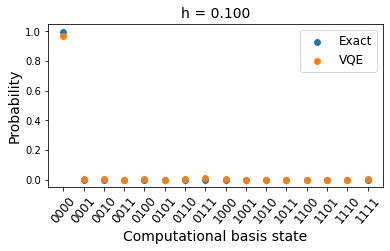


==================== h = 0.316 ====================
Ground state ENERGY per qubit:
	Exact: -1.124
	VQE: -0.655
MAGNETISATION per qubit:
	Exact: 0.988
	VQE: 0.756
FIDELITY: 0.993

Ground state EIGENVECTOR:
	Exact: [-0.988 -0.075 -0.075 -0.011 -0.075 -0.006 -0.011 -0.002 -0.075 -0.011
 -0.006 -0.002 -0.011 -0.002 -0.002 -0.003]
	VQE: [ 0.989  0.101  0.076  0.037  0.029 -0.04  -0.002 -0.004  0.047  0.006
  0.012  0.003 -0.015 -0.006 -0.006 -0.003]


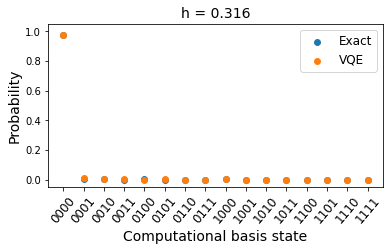


==================== h = 0.750 ====================
Ground state ENERGY per qubit:
	Exact: -1.239
	VQE: -0.818
MAGNETISATION per qubit:
	Exact: 0.906
	VQE: 0.605
FIDELITY: 0.944

Ground state EIGENVECTOR:
	Exact: [-0.925 -0.171 -0.171 -0.062 -0.171 -0.034 -0.062 -0.034 -0.171 -0.062
 -0.034 -0.034 -0.062 -0.034 -0.034 -0.075]
	VQE: [-8.380e-01 -2.099e-01 -2.218e-01 -1.556e-01 -2.446e-01 -3.253e-02
 -3.686e-02 -2.615e-02 -3.236e-01 -8.189e-02 -1.878e-02 -4.373e-02
 -5.862e-02 -2.024e-04 -1.073e-02 -8.475e-03]


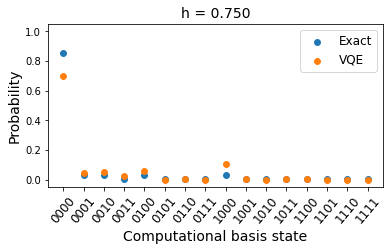


==================== h = 1.000 ====================
Ground state ENERGY per qubit:
	Exact: -1.356
	VQE: -0.763
MAGNETISATION per qubit:
	Exact: 0.747
	VQE: -0.168
FIDELITY: 0.469

Ground state EIGENVECTOR:
	Exact: [-0.837 -0.214 -0.214 -0.109 -0.214 -0.063 -0.109 -0.082 -0.214 -0.109
 -0.063 -0.082 -0.109 -0.082 -0.082 -0.18 ]
	VQE: [-0.304 -0.22  -0.128 -0.259 -0.107 -0.089 -0.158 -0.306 -0.204 -0.154
 -0.147 -0.289 -0.248 -0.196 -0.277 -0.539]


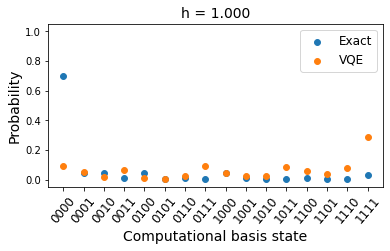


==================== h = 1.250 ====================
Ground state ENERGY per qubit:
	Exact: -1.515
	VQE: -1.010
MAGNETISATION per qubit:
	Exact: 0.517
	VQE: 0.159
FIDELITY: 0.899

Ground state EIGENVECTOR:
	Exact: [-0.717 -0.238 -0.238 -0.154 -0.238 -0.093 -0.154 -0.134 -0.238 -0.154
 -0.093 -0.134 -0.154 -0.134 -0.134 -0.273]
	VQE: [0.524 0.221 0.376 0.213 0.263 0.171 0.223 0.232 0.156 0.109 0.139 0.173
 0.126 0.175 0.172 0.356]


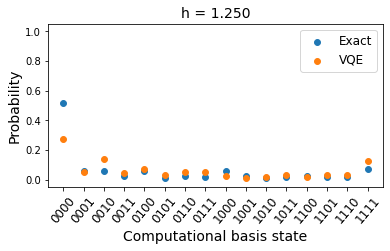


==================== h = 1.500 ====================
Ground state ENERGY per qubit:
	Exact: -1.708
	VQE: -1.181
MAGNETISATION per qubit:
	Exact: 0.338
	VQE: -0.247
FIDELITY: 0.712

Ground state EIGENVECTOR:
	Exact: [-0.612 -0.248 -0.248 -0.184 -0.248 -0.116 -0.184 -0.171 -0.248 -0.184
 -0.116 -0.171 -0.184 -0.171 -0.171 -0.318]
	VQE: [-0.19  -0.186 -0.178 -0.256 -0.155 -0.169 -0.186 -0.307 -0.169 -0.166
 -0.172 -0.249 -0.253 -0.274 -0.313 -0.515]


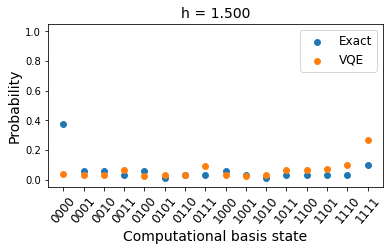


==================== h = 2.000 ====================
Ground state ENERGY per qubit:
	Exact: -2.144
	VQE: -1.471
MAGNETISATION per qubit:
	Exact: 0.167
	VQE: 0.036
FIDELITY: 0.937

Ground state EIGENVECTOR:
	Exact: [-0.485 -0.253 -0.253 -0.215 -0.253 -0.146 -0.215 -0.207 -0.253 -0.215
 -0.146 -0.207 -0.215 -0.207 -0.207 -0.333]
	VQE: [-0.315 -0.25  -0.197 -0.243 -0.196 -0.203 -0.221 -0.281 -0.334 -0.265
 -0.215 -0.262 -0.21  -0.218 -0.235 -0.3  ]


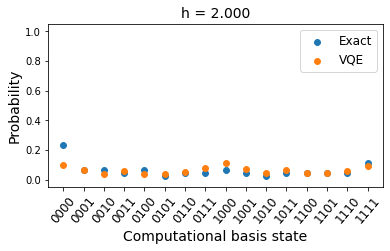


==================== h = 3.162 ====================
Ground state ENERGY per qubit:
	Exact: -3.247
	VQE: -1.839
MAGNETISATION per qubit:
	Exact: 0.065
	VQE: -0.243
FIDELITY: 0.701

Ground state EIGENVECTOR:
	Exact: [0.374 0.254 0.254 0.237 0.254 0.181 0.237 0.232 0.254 0.237 0.181 0.232
 0.237 0.232 0.232 0.312]
	VQE: [0.005 0.114 0.097 0.153 0.073 0.221 0.213 0.31  0.203 0.123 0.232 0.233
 0.352 0.254 0.431 0.468]


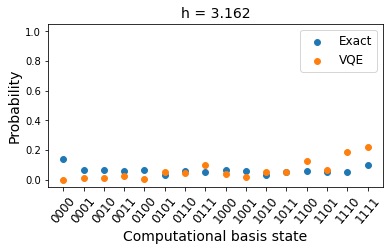


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.026
	VQE: -6.400
MAGNETISATION per qubit:
	Exact: 0.012
	VQE: 0.125
FIDELITY: 0.961

Ground state EIGENVECTOR:
	Exact: [0.282 0.252 0.252 0.249 0.252 0.226 0.249 0.247 0.252 0.249 0.226 0.247
 0.249 0.247 0.247 0.27 ]
	VQE: [0.353 0.263 0.263 0.194 0.217 0.273 0.213 0.224 0.351 0.271 0.215 0.172
 0.225 0.286 0.188 0.201]


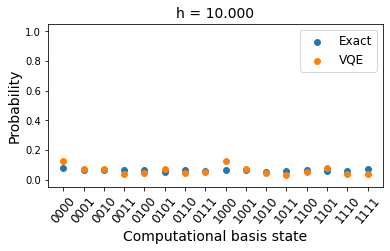


==================== h = 31.623 ====================
Ground state ENERGY per qubit:
	Exact: -31.631
	VQE: -22.771
MAGNETISATION per qubit:
	Exact: 0.003
	VQE: 0.009
FIDELITY: 0.000

Ground state EIGENVECTOR:
	Exact: [0.26  0.251 0.251 0.25  0.251 0.242 0.25  0.249 0.251 0.25  0.242 0.249
 0.25  0.249 0.249 0.256]
	VQE: [ 0.21  -0.221  0.411 -0.432  0.077 -0.081  0.173 -0.181  0.183 -0.192
  0.412 -0.434  0.041 -0.043  0.146 -0.154]


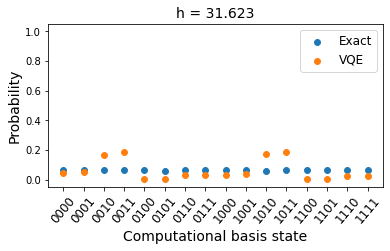

In [66]:
fidelity_list = compute_fidelities(exact_eigenvector_list, vqe_eigenvector_list)
results_list = zip(h_list, exact_energy_list, exact_eigenvector_list, exact_magnetisation_z_list,
                   vqe_energy_list, vqe_eigenvector_list, vqe_magnetisation_z_list, fidelity_list)
print_all_results(results_list)

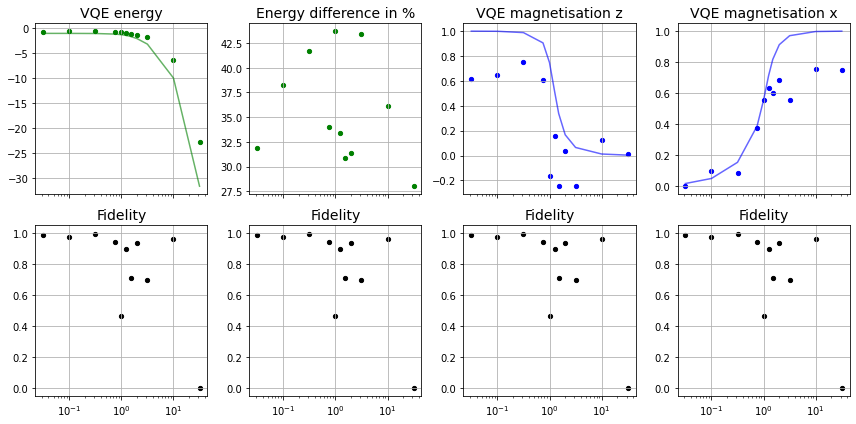

In [67]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)

axes[0, 0].scatter(h_list, vqe_energy_list, s=18, c='g')
axes[0, 0].plot(h_list, exact_energy_list, c='g', alpha=0.6)
axes[0, 0].set_title("VQE energy", fontsize=14)
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True)

axes[0, 1].scatter(h_list, 100 * np.abs((np.array(vqe_energy_list) - np.array(exact_energy_list)) / np.array(exact_energy_list)), s=18, c='g')
axes[0, 1].set_title("Energy difference in %", fontsize=14)
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True)

axes[0, 2].scatter(h_list, vqe_magnetisation_z_list, s=18, c='b')
axes[0, 2].plot(h_list, exact_magnetisation_z_list, c='b', alpha=0.6)
axes[0, 2].set_title("VQE magnetisation z", fontsize=14)
axes[0, 2].grid(True)

axes[0, 3].scatter(h_list, vqe_magnetisation_x_list, s=18, c='b')
axes[0, 3].plot(h_list, exact_magnetisation_x_list, c='b', alpha=0.6)
axes[0, 3].set_title("VQE magnetisation x", fontsize=14)
axes[0, 3].grid(True)

axes[1, 0].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 0].set_ylim(-0.05, 1.05)
axes[1, 0].set_title("Fidelity", fontsize=14)
axes[1, 0].grid(True)

axes[1, 1].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 1].set_ylim(-0.05, 1.05)
axes[1, 1].set_title("Fidelity", fontsize=14)
axes[1, 1].grid(True)

axes[1, 2].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 2].set_ylim(-0.05, 1.05)
axes[1, 2].set_title("Fidelity", fontsize=14)
axes[1, 2].grid(True)

axes[1, 3].scatter(h_list, fidelity_list, s=18, c='k')
axes[1, 3].set_ylim(-0.05, 1.05)
axes[1, 3].set_title("Fidelity", fontsize=14)
axes[1, 3].grid(True)

plt.tight_layout()
fig.savefig("spsa_ibmmiti_100iter_bias0p1_ry_depth2_full.png")

The results look quite good. We can clearly see the phase transition and the trend in energies is correct. Energy errors are mostly within 10%. Also, fidelities are all above 0.8, even at the transition, which is great. There is a bit worse performance at high fields, but the trend is still clear.

NOTE: All of the tests are done with 1024 shots and bias of 0.1!

Without choosing any initial_point and using 2-layer, RyRz linear ansatz, the COBYLA and SLSQP have extreme troubles finding the right states (especially SLSQP). However, SPSA deals quite well with noisy models - the only issue is that we need 500-1000 iterations, which takes about 10 minutes for each value of field. Also, it is not free from the error resulting from falling into opposite magnetisation state for low $h$.

Using 'full' entanglement makes results worse than 'linear'. SPSA does a fair job with 100 iterations and error mitigation so that we can detect a phase transition, but the errors are very large. Depth of more than 2 makes it very difficult for SPSA at 100 iterations. Whether it is better to have Ry or RyRz ansatz is difficult to say. Since there is no significant difference in results (it seems), I will just go with simpler Ry ansatz.

**Final configuration chosen for real device:**
- *optimizer = SPSA(maxiter=100)*
- *ansatz = EfficientSU2('linear', reps=2, su2_gates=['ry'])*